In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative, oscilador,sol_x, Param

In [117]:
plt.style.use('cyberpunk')
#mplcyberpunk.make_lines_glow()

### In this notebook we will compute the solutions of the damped harmonic oscillator , defined for the diffetrential equation:

$$\ddot{x} + \delta \dot{x} + \omega_0^2 x = 0$$

The training dataset wil be the vectorial product:

$$T=[t_i, t_f] \times [x_{0,i} , x_{0,f}]$$

In [118]:
#The time and initial position intervals
ti=0.0
tf=10.0
#t=torch.linspace(ti,tf,60).view(-1,1)

x0_i=-0.5
x0_f=0.6

# v0_i=0.0
# v0_f=0.6

# delta_i=0.0
# delta_f=0.3

# omega_i=0.0
# omega_f=0.3

T=torch.cartesian_prod(torch.linspace(ti,tf,45),
                       torch.arange(x0_i,x0_f,0.1))
                     #   torch.arange(x0_i,x0_f,0.1))
                    #    torch.linspace(delta_i,delta_f,8),
                    #    torch.linspace(omega_i,omega_f,8))

#We shuffle the dataset to prevent overfitting.
T=T[torch.randperm(T.shape[0])]

In [119]:
if torch.cuda.is_available(): T.cuda()
else: print('no cuda service available')

no cuda service available


In [120]:
# This is the training dataset, and the batch size is then 1100
T.shape

torch.Size([495, 2])

In [121]:
#PINN architecture
nodos=16
ANN = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


To compute the derivative is critical to evaluate the ANN into the differential equation.
Then, the function $\texttt{nth-derivative}$ compute the $n$-order derivative of the $y_j$ element of a vector function with respect to the $x_i$ variable:

$$F(x_1, x_2,...x_i, ...) \longrightarrow (y_1, y_2,..., y_j, ...)$$


In [122]:
# d²ANN/dt²
nth_derivative(ANN, T,0,0, 2)

tensor([[-2.9964e-03],
        [ 1.3894e-02],
        [-2.2014e-03],
        [-1.5396e-03],
        [-1.0379e-03],
        [-9.1744e-04],
        [-2.6726e-03],
        [-1.9925e-03],
        [-2.2564e-03],
        [ 2.1308e-02],
        [ 2.3594e-02],
        [ 1.1844e-03],
        [-1.6693e-03],
        [ 1.4419e-02],
        [-2.2846e-03],
        [-2.1481e-03],
        [-2.4949e-03],
        [ 1.8698e-02],
        [-2.2098e-03],
        [-2.2862e-03],
        [ 1.6716e-05],
        [ 2.0247e-02],
        [-1.1030e-03],
        [ 2.0686e-02],
        [ 8.0919e-03],
        [ 4.7111e-03],
        [-1.4117e-03],
        [ 7.5752e-03],
        [ 8.0654e-03],
        [-2.1119e-03],
        [-2.5284e-03],
        [ 1.4504e-02],
        [-2.8718e-03],
        [-2.0197e-03],
        [-1.9288e-03],
        [ 2.1834e-02],
        [-1.0238e-03],
        [-6.7117e-04],
        [-1.3616e-03],
        [ 8.0485e-03],
        [ 1.4411e-03],
        [ 2.0176e-02],
        [ 1.2807e-02],
        [ 6

In order to meet the initial conditions of the differential equation (Neuman conditions), a reparametrization of the function must be made:

$$u(t,x_0) \longrightarrow \hat{u}(t,x_0)=x_0 + (t-t_0)v_0 + (1-e^{-(t-t_0)})^2 u$$

In [123]:
def Param(T,net=ANN):
    out = net(T)
    a=(T[:,0]-ti)*1.0
    b=1-torch.exp(ti-T[:,0])
    #return torch.reshape(T[:,1],out.size()) + b*out
    return T[:,1].view(-1,1) +a.view(-1,1) +b.view(-1,1)**2 * out


In [124]:
Param(T)

tensor([[ 5.4691e+00],
        [ 8.4631e-01],
        [ 7.0453e+00],
        [ 7.7464e+00],
        [ 8.7580e+00],
        [ 9.0144e+00],
        [ 5.7458e+00],
        [ 7.5297e+00],
        [ 5.1320e+00],
        [ 1.4801e+00],
        [ 1.8716e+00],
        [ 3.6321e+00],
        [ 7.5182e+00],
        [ 1.0413e+00],
        [ 4.9304e+00],
        [ 4.5504e+00],
        [ 5.0585e+00],
        [ 1.8265e+00],
        [ 5.2325e+00],
        [ 6.6610e+00],
        [ 3.8614e+00],
        [ 1.8962e+00],
        [ 8.8710e+00],
        [ 1.6944e+00],
        [ 2.9817e+00],
        [ 3.2301e+00],
        [ 8.4428e+00],
        [ 2.9022e+00],
        [ 4.2100e-01],
        [ 7.0177e+00],
        [ 6.0754e+00],
        [ 8.5858e-01],
        [ 5.6719e+00],
        [ 7.4018e+00],
        [ 7.3742e+00],
        [ 1.9836e+00],
        [ 8.9710e+00],
        [ 9.6977e+00],
        [ 8.1310e+00],
        [ 4.0000e-01],
        [ 3.6077e+00],
        [-4.0000e-01],
        [ 2.7378e+00],
        [ 2

In [125]:
def cost(t):
    #compute the derivatives os the function with respect to t
    Dt = nth_derivative(Param, t,0,0,1)
    DDt = nth_derivative(Param, t,0,0,2) 
    #delta = T[:, 3]
    #delta = delta.view(-1, 1)
    #omega = T[:, 4]

    osc = DDt + 1.5*Dt + 9.0*Param(t)
    #osc = DDt + t[:,3].view(-1,1)*Dt + t[:,4].view(-1,1)*Param(t)
    return torch.linalg.norm(osc)**2
    #return torch.mean(osc**2)

In [126]:
cost(T)

tensor(1360135.3750, grad_fn=<PowBackward0>)

In [152]:
#4 Error and optimizer
learning_rate=0.01
epocas=4000

#optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate, weight_decay=0.1)
#optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

Training: 100%|█████████████████████████████████████| 2500/2500 [00:33<00:00, 73.76it/s, loss=0.644]


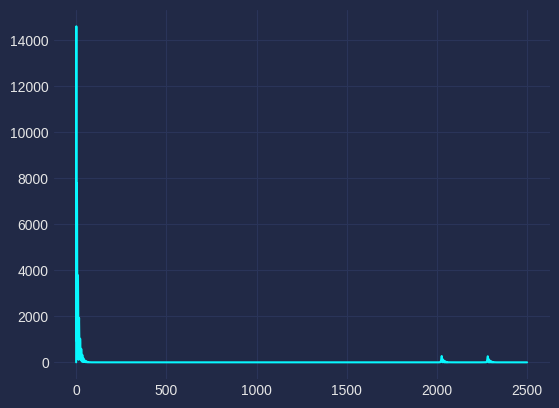

In [153]:
#loop de entrenamiendo 
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(T) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)

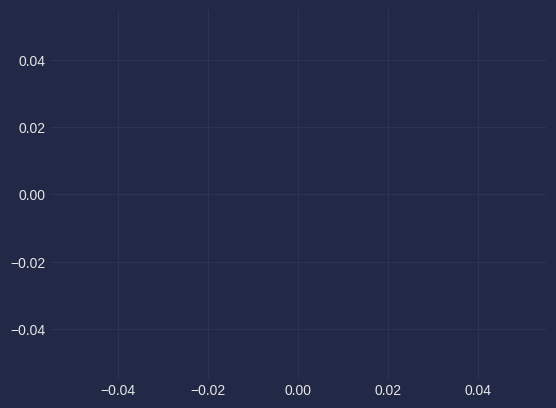

In [146]:
plt.plot(range(epocas)[7500:],errores[7500:])

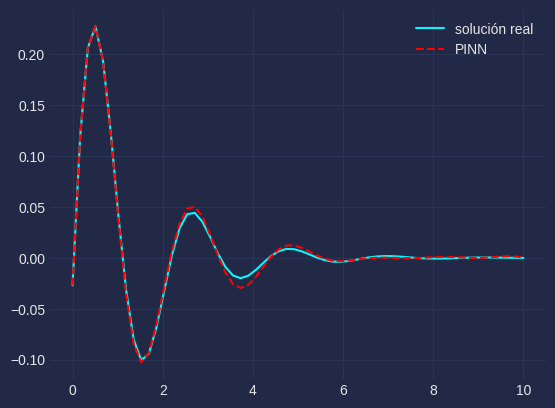

In [163]:
pos_ini=-0.027
vel_ini=1.0
d=1.5
omega=3

t0 = torch.linspace(ti,tf,60)
x0 = pos_ini*torch.ones([t0.shape[0],1])
#v0 = vel_ini*torch.ones([t0.shape[0],1])
# delta0 = d*torch.ones([t0.shape[0],1])
# omega0 = omega*torch.ones([t0.shape[0],1])

X=torch.cat((t0.view(-1,1),x0),1)
#X.cuda()
#plt.plot(t0, -torch.sin(t0)+2*t0+pos_ini, label='solución real')
plt.plot(t0.detach(), sol_x([pos_ini,vel_ini], t0, d, omega), label='solución real')
plt.plot(X[:,0],Param(X).detach().numpy(),'--r', label='PINN')
#plt.plot(t0.view(-1,1),Param(t0.view(-1,1)).detach().numpy(),'--r', label='PINN')
plt.legend()

In [131]:
%timeit Param(X).detach().numpy()

336 µs ± 7.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [132]:
%timeit sol_x([pos_ini,vel_ini], t0, d, omega) #odeint

1.3 ms ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [158]:
torch.save(ANN.state_dict(),'oscilador_dict')

## For evaluating the model, and perform a benchmarking we use:



In [2]:
#PINN architecture
nodos=16
ANN = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [3]:
model=ANN

In [4]:
model.load_state_dict(torch.load('oscilador_dict'))
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [5]:
#The time and initial position intervals
ti=0.0
tf=10.0
#t=torch.linspace(ti,tf,60).view(-1,1)

x0_i=-0.5
x0_f=0.6

# v0_i=0.0
# v0_f=0.6

# delta_i=0.0
# delta_f=0.3

# omega_i=0.0
# omega_f=0.3

T=torch.cartesian_prod(torch.linspace(ti,tf,45),
                       torch.arange(x0_i,x0_f,0.1))
                     #   torch.arange(x0_i,x0_f,0.1))
                    #    torch.linspace(delta_i,delta_f,8),
                    #    torch.linspace(omega_i,omega_f,8))

#We shuffle the dataset to prevent overfitting.
T=T[torch.randperm(T.shape[0])]

In [6]:
model(T)

tensor([[ -9.5712],
        [ -7.0356],
        [ -5.7230],
        [ -4.2842],
        [ -4.9543],
        [ -9.4934],
        [ -9.4196],
        [ -4.0397],
        [ -4.5409],
        [ -6.8552],
        [ -7.0046],
        [ -7.7097],
        [ -5.6688],
        [ -7.8854],
        [ -5.6216],
        [ -3.3828],
        [ -3.4565],
        [ -5.2539],
        [ -1.1352],
        [ -9.8480],
        [ -6.5087],
        [ -4.7461],
        [ -8.9929],
        [ -2.7978],
        [ -9.1477],
        [ -6.0873],
        [ -3.7400],
        [ -3.1129],
        [ -7.2354],
        [ -7.7857],
        [ -3.3314],
        [ -7.6587],
        [ -8.1420],
        [ -8.8126],
        [ -5.8243],
        [ -4.8374],
        [ -8.8244],
        [ -1.1074],
        [ -6.0654],
        [ -3.8568],
        [ -9.4998],
        [ -9.2937],
        [ -4.1896],
        [ -3.7966],
        [ -6.6095],
        [ -8.4569],
        [ -8.4855],
        [ -4.2404],
        [ -6.6543],
        [ -6.7880],


In [54]:
t_mesh = np.linspace(ti, tf, 100)
x0_mesh = np.linspace(x0_i, x0_f, 100)

t_param = torch.linspace(ti, tf, 100)
x0_param = torch.linspace(x0_i, x0_f, 100)

In [85]:
mesh=np.ones((100,100))

In [94]:
for i in range(100):
    for j in range(100):
        a=Param(torch.tensor([[t_param[i],x0_param[j]]]), net=model).detach().numpy()
        b=sol_x([x0_mesh[j],1.0], [t_mesh[i]], 1.5, 3.0)
        
        mesh[i,j] =  abs(a-b)


/tmp/ipykernel_7037/1553132492.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mesh[i,j] =  abs(a-b)


In [95]:
mesh

array([[0.00000000e+00, 6.62273847e-10, 1.32454764e-09, ...,
        2.51664056e-08, 5.29819077e-09, 2.38418579e-08],
       [1.13464087e-01, 1.13026171e-01, 1.12586288e-01, ...,
        6.83638705e-02, 6.79666943e-02, 6.75729156e-02],
       [2.41989911e-01, 2.40403592e-01, 2.38808869e-01, ...,
        7.55620850e-02, 7.41420931e-02, 7.27369428e-02],
       ...,
       [4.98861313e-01, 4.88058239e-01, 4.77241813e-01, ...,
        5.77226554e-01, 5.87832218e-01, 5.98401642e-01],
       [4.99954224e-01, 4.89128261e-01, 4.78288947e-01, ...,
        5.76419746e-01, 5.86891895e-01, 5.97324944e-01],
       [5.01034737e-01, 4.90179210e-01, 4.79306518e-01, ...,
        5.74326430e-01, 5.84622150e-01, 5.94872093e-01]])

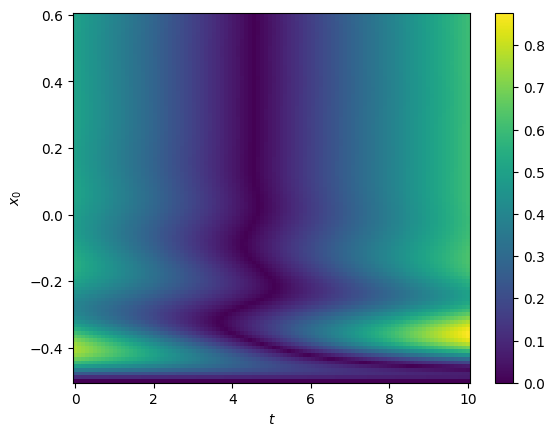

In [97]:
plt.pcolormesh(t_mesh, x0_mesh, mesh, cmap='viridis')
plt.xlabel('$t$')
plt.ylabel('$x_0$')
plt.colorbar()
plt.show()